In [1]:
!pip install -U "ray[rllib]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

os.chdir('/content/drive/MyDrive/Colab Notebooks/rllib')

In [58]:
import pickle
import glob
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import random
import easydict
import datetime
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy import odr
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
from gymnasium.spaces import Box
from gymnasium.wrappers import NormalizeObservation
from gymnasium.wrappers import NormalizeReward

import os
import ray
from ray import train, tune, air
from ray.tune import ResultGrid
from ray.tune.logger import pretty_print
from ray.tune.registry import get_trainable_cls
from ray.tune.registry import register_env
from ray.rllib.algorithms.algorithm import Algorithm

from Sim.utils.data_reader import LettuceDataset

In [29]:
version = 'baseline'
base_tmp_folder = './result'
direcrory = base_tmp_folder+'/models/'
model_dir = direcrory + version
model_path = model_dir + '/model/'
scaler_dir = model_dir + '/scaler/'

env_config = easydict.EasyDict({
    'model1_dir': model_path+'simulator_greenhouse.pkl',
    'model2_dir': model_path+'simulator_crop_front.pkl',
    'model3_dir': model_path+'simulator_crop_back.pkl',
    'scaler1_x': scaler_dir+'greenhouse_x_scaler.pkl',
    'scaler1_y': scaler_dir+'greenhouse_y_scaler.pkl',
    'scaler2_x': scaler_dir+'crop_front_x_scaler.pkl',
    'scaler2_y': scaler_dir+'crop_front_y_scaler.pkl',
    'scaler3_x': scaler_dir+'crop_back_x_scaler.pkl',
    'scaler3_y': scaler_dir+'crop_back_y_scaler.pkl',
    'linreg_dir': model_path+'PARsensor_regression_parameters.pkl',
    'weather_dir': model_path+'weather.npy'
})

In [31]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=120):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        return x

In [32]:
class Economic:
    def __init__(self, dayAction, dayState, dayReward):
        self.dayAction = dayAction  # [heating temp, ventilation, lamps, scr_enrg, scr_blck, co2]
        self.dayState = dayState  # [AirT, AirRH, Airppm]
        self.dayReward = dayReward  # [FW]

    def cal_economic(self):

        gains = self.cal_gains()
        elecCost = self.elec_cost()
        co2Cost = self.co2_cost()
        heatCost = self.heat_cost()

        variableCosts = elecCost + co2Cost + heatCost
        balance = gains - variableCosts
        # balance = gains

        economic = {'balance': balance,
                    'gains': gains,
                    'variableCosts': variableCosts,
                    'elecCost': elecCost,
                    'co2Cost': co2Cost,
                    'heatCost': heatCost}

        return economic

    def cal_gains(self):
        # price = 3.5
        price = 3.185
        # price = 3.1
        # price = 2.94
        return self.dayReward[0] * price

    def elec_cost(self):
        lmp_use = self.dayAction[:, 2]
        days = len(lmp_use) // 24

        power = 185 / 2.1

        price = np.array(([0.04] * 7 + [0.08] * 16 + [0.04] * 1) * days)
        cost = np.sum(np.array(lmp_use) * price * power / 1000)

        return cost

    def co2_cost(self):
        CO2_setpoint = self.dayAction[:, 5]
        Airppm = self.dayState[:, 2]

        McConAir_max = 4e-6
        co2_use = CO2_setpoint - Airppm
        co2_use[co2_use > 0] = McConAir_max
        co2_use[co2_use <= 0] = 0

        price1, price2 = 0.08, 0.2
        kgCO2 = sum(co2_use) * 3600
        firstTranche = min(kgCO2, 12)
        secondTranche = kgCO2 - firstTranche
        cost = firstTranche * price1 + secondTranche * price2

        return cost

    def heat_cost(self):
        temp_setpoint = self.dayAction[:, 0]
        AirT = self.dayState[:, 0]

        PConPipe1_max = np.full((24), 60)
        heat_use = (PConPipe1_max - AirT) * 2.1

        heat = temp_setpoint - AirT
        heat_use[heat <= 0] = 0

        price = 0.03
        cost = sum(heat_use) * price / 1000

        return cost

In [33]:
class GreenhouseEnv(gym.Env):

    def __init__(self, config):
        self.net1 = Net(14, 3, 300)
        self.net1.load_state_dict(torch.load(
            config['model1_dir'], map_location=torch.device('cpu')))
        self.net2 = Net(5, 1, 300)
        self.net2.load_state_dict(torch.load(
            config['model2_dir'], map_location=torch.device('cpu')))
        self.net3 = Net(2, 1, 600)
        self.net3.load_state_dict(torch.load(
            config['model3_dir'], map_location=torch.device('cpu')))
        self.net1.eval()
        self.net2.eval()
        self.net3.eval()

        self.scaler1_x = pickle.load(open(config['scaler1_x'], 'rb'))
        self.scaler1_y = pickle.load(open(config['scaler1_y'], 'rb'))
        self.scaler2_x = pickle.load(open(config['scaler2_x'], 'rb'))
        self.scaler2_y = pickle.load(open(config['scaler2_y'], 'rb'))
        self.scaler3_x = pickle.load(open(config['scaler3_x'], 'rb'))
        self.scaler3_y = pickle.load(open(config['scaler3_y'], 'rb'))

        self.linreg = pickle.load(open(config['linreg_dir'], 'rb'))

        self.full_weather = np.load(config['weather_dir'])

        self.observation_space = self.observation_space()
        self.action_space = self.action_space()

        self.reset()

        self._max_episode_steps = 48

    def observation_space(self):
        # AirT * 24, AirRH * 24, Airppm * 24; GR; FW
        low = np.concatenate(([0 for _ in range(24)], [0 for _ in range(24)],
                               [0 for _ in range(24)], [0, 0]))
        high = np.concatenate(([40 for _ in range(24)], [100 for _ in range(24)],
                                [6000 for _ in range(24)], [10, 300]))
        return Box(low=low, high=high, dtype=np.float32)

    def action_space(self):
        # heating temp, ventilation, lamps, scr_enrg, scr_blck, co2
        low = np.concatenate(
            ([0 for _ in range(24)], [0 for _ in range(24)], [0 for _ in range(24)], [0 for _ in range(24)],
             [0 for _ in range(24)], [0 for _ in range(24)]))
        high = np.concatenate(
            ([40 for _ in range(24)], [1 for _ in range(24)], [1 for _ in range(24)], [1 for _ in range(24)],
             [1 for _ in range(24)], [6000 for _ in range(24)]))

        return Box(low=low, high=high, dtype=np.float32)

    def f_co2(self, co2):
        beta_co2 = 400
        return 1 - np.exp(-co2 / beta_co2)

    def f_par(self, par):
        beta_par = 200
        return 1 - np.exp(-par / beta_par)

    def f_t(self, t):
        t_opt = 25
        t_diff = np.abs(t - t_opt)
        t_rng = 25
        if t_diff < t_rng:
            return 1 - (t_diff / t_rng) ** 2
        else:
            return 0

    def g(self, co2, par, t, fw, d, h):
        day_fw = fw[d*24:(d+1)*24]
        cum_gr_t = ((day_fw[h] + 1)/(day_fw[0] + 1)) ** (1/(h+1)) - 1
        hour_gr = 1.194 ** (1 / 12)
        max_gr = np.array([hour_gr, cum_gr_t], dtype=object)
        max_gr = np.min(max_gr)
        co2_r = self.f_co2(co2)
        par_r = self.f_par(par)
        t_r = self.f_t(t)
        return max_gr * co2_r * par_r * t_r

    def get_outside_weather(self, day_index):
        if day_index < 48:
            return self.full_weather[day_index * 24:(day_index + 1) * 24]
        else:
            mv_idx = day_index - 48
            return self.full_weather[(day_index - mv_idx) * 24:(day_index + 1-mv_idx) * 24]

    def calculate_reward(self, dayAction, dayState, dayReward):
        economic = Economic(dayAction=dayAction, dayState=dayState,
                            dayReward=dayReward).cal_economic()
        reward = economic['balance']

        return reward, economic

    def crop_weight(self, t):
        cm = 20
        rm = 0.14
        tb = 35.4
        w = cm/rm*np.log(1+np.exp(rm*(t-tb)))
        return w

    def poly_fw(self):
        days = 48
        d = np.array(range(days))

        days_fw = self.crop_weight(d)
        fw_model = odr.polynomial(5)
        FW = odr.Data(d, days_fw)
        odr_fw = odr.ODR(FW, fw_model)
        output = odr_fw.run()  # running ODR fitting
        poly = np.poly1d(output.beta[::-1])
        return poly(np.linspace(0, days, days * 24)).reshape(-1, 1)

    def _get_obs(self):
        observation = np.hstack((self.day_inside_weather, self.crop_state, self.fw))
        return observation

    def step(self, action):
        assert len(action) == 144, 'wrong input control dimension'

        # self.action = action

        action = action.reshape((6, 24)).T

        day_outside_weather = self.get_outside_weather(self.day_index)

        day_inside_weather = np.zeros((24, 3))

        cum_gr = 1  # cumulative growth rate

        days_fw = self.poly_fw()

        for i in range(24):
            # each hour
            # Tout, Rhout, Iglob, Windsp, PARout
            cur_outside_weather = day_outside_weather[i]
            cur_control = action[i]  # temp, vent, lamp, scr_enrg, scr_black, co2
            cur_inside_weather = self.inside_weather  # Tair, Rhair, CO2air
            day_inside_weather[i, :] = cur_inside_weather
            input1 = np.hstack(
                (cur_outside_weather, cur_control, cur_inside_weather))
            input1 = input1.reshape(1, -1)
            # input1 = input1.repeat(5,axis=0)
            input1_normal = self.scaler1_x.transform(input1)
            input1_normal = torch.tensor(input1_normal, dtype=torch.float)
            output1_normal = self.net1(input1_normal).detach().numpy()
            # output1_normal = output1_normal.reshape(1,-1)
            output1 = self.scaler1_y.inverse_transform(output1_normal)[0]
            output1 = np.clip(output1, [0, 0, 0], [40, 100, 6000])
            self.inside_weather = output1

            # PARsensor calculation
            PARsensor = self.linreg.predict(input1[0, [2, 4, 7]].reshape(1, -1))
            PARsensor = PARsensor if PARsensor > 50.0 else 0.0
            # PARsensor = np.array(PARsensor)
            # PARsensor = PARsensor.reshape(1,-1)

            # input2 = np.hstack(
            #     (self.inside_weather, PARsensor, self.crop_state))
            # # print(input2)
            # input2 = input2.reshape(1, -1)
            # input2_normal = self.scaler2_x.fit_transform(input2)
            # input2_normal = torch.tensor(input2_normal, dtype=torch.float)
            # output2_normal = self.net2(input2_normal).detach().numpy()
            # output2 = self.scaler2_y.inverse_transform(output2_normal)[0]

            # output2[-1] = np.maximum(self.crop_state[-1], output2[-1])

            # self.crop_state = output2  # LAI, PlantLoad, NetGrowth
            # print(self.inside_weather)
            # print(self.crop_state)

            gr = self.g(co2=output1[2],
                        par=PARsensor,
                        t=output1[0],
                        fw=days_fw,
                        d=self.day_index,
                        h=i)
            cum_gr *= (1 + gr)

        # input3 = np.concatenate((self.crop_state, self.fw))
        # # print(input3)
        # input3 = input3.reshape(1, -1)
        # input3_normal = self.scaler3_x.transform(input3)
        # input3_normal = torch.tensor(input3_normal, dtype=torch.float)
        # output3_normal = self.net3(input3_normal).detach().numpy()
        # output3 = self.scaler3_y.inverse_transform(output3_normal)[0]
        #
        # cur_fw = self.fw
        #
        # output3 = output3 if output3 > 0.1 else np.array([0])
        # output3 = np.maximum(output3, self.fw)
        # self.fw = output3
        # print('fw', self.fw)

        # day_fw = (self.fw - cur_fw) + self.store_fw
        # harvest = 1e-3
        # if day_fw < harvest:
        #     self.store_fw += self.fw - cur_fw
        #     day_fw = np.zeros(1)
        #
        # else:
        #     self.store_fw = np.zeros(1)

        cur_fw = self.fw.copy()
        self.fw *= cum_gr
        day_fw = self.fw - cur_fw

        reward, economic = self.calculate_reward(
            dayAction=action, dayState=day_inside_weather, dayReward=day_fw)

        self.day_inside_weather = day_inside_weather.T.reshape(1, -1)[0]
        obs = self._get_obs()

        self.day_index += 1

        done = self.day_index >= self._max_episode_steps

        return obs, reward, done, False, economic

    def reset(self, seed=None, options=None):
        random.seed(seed)

        self.inside_weather = np.array([17.27, 61.83, 737.31])
        self.day_inside_weather = np.concatenate((np.random.randint(20, 24, 24),
                                                  np.random.randint(50, 80, 24),
                                                  np.random.randint(600, 800, 24)))

        self.crop_state = np.zeros(1)

        self.fw = np.ones(1)

        self.store_fw = np.zeros(1)

        self.day_index = 0

        observation = self._get_obs()

        return observation, {}

In [34]:
# Register the custom env
def env_creator(env_config):
    env = GreenhouseEnv(env_config)
    # env = NormalizeObservation(env)
    env = NormalizeReward(env)
    return env

register_env("greenhouse", env_creator)

In [35]:
def get_rl_sim(checkpoint_path, env_config):
    algo = Algorithm.from_checkpoint(checkpoint_path)

    env = GreenhouseEnv(env_config)
    obs, _ = env.reset()

    done = False
    reward = []
    economic = {'balance': [],
                'gains': [],
                'variableCosts': [],
                'elecCost': [],
                'co2Cost':[],
                'heatCost': []}

    while not done:
        a = algo.compute_single_action(obs)
        obs, r, done, _, info = env.step(a)
        reward.append(r)

        for key, val in info.items():
            economic[key].append(val)

    return reward, economic

In [36]:
def simOurModel(period_action, env):
    env.reset()

    dims = 24
    day = 0
    done = False
    reward = []
    economic = {'balance': [],
                'gains': [],
                'variableCosts': [],
                'elecCost': [],
                'co2Cost': [],
                'heatCost': []}

    while not done:
        a = period_action[day*dims: (day+1)*dims, :]

        a = a.reshape((-1), order='F')
        _, r, done, _, ec = env.step(a)
        day += 1
        reward.append(float(r))

        for k, v in ec.items():
            economic[k].append(v)

    return reward, economic

In [37]:
def get_sim_res(args, env_config):
    tmp_folder = os.path.join(args.base_tmp_folder, 'models/%s' % args.version)

    wur_reader = LettuceDataset(args.base_input_path, tmp_folder)
    train_data = wur_reader.read_data(args.base_input_path)
    full_train_x, full_train_y = wur_reader.data_process(train_data)

    period_action = full_train_x[0, :, 5:11]
    # X = np.concatenate((period_action, period_action[-49:, :]), axis=0)

    env = GreenhouseEnv(env_config)
    reward, economic = simOurModel(period_action, env)

    return reward, economic

In [38]:
def get_results(args, env_config):
    _, sac_economic = get_rl_sim(args.sac_checkpoint, env_config)
    _, ppo_economic = get_rl_sim(args.ppo_checkpoint, env_config)
    _, baseline_economic = get_sim_res(args, env_config)

    price = 3.185

    # production
    production_sac = np.cumsum(sac_economic['gains']) / price
    production_sac_dict = {'xlabel': 'Date',
                        'ylabel': 'Kg/m$^2$',
                        'x': range(len(production_sac)),
                        'y': production_sac}
    production_ppo = np.cumsum(ppo_economic['gains']) / price
    production_ppo_dict = {'xlabel': 'Date',
                        'ylabel': 'Kg/m$^2$',
                        'x': range(len(production_ppo)),
                        'y': production_ppo}
    production_baseline = np.cumsum(baseline_economic['gains']) / price
    production_baseline_dict = {'xlabel': 'Date',
                        'ylabel': 'Kg/m$^2$',
                        'x': range(len(production_baseline)),
                        'y': production_baseline}

    # cost
    cost_sac = np.cumsum(sac_economic['variableCosts'])
    cost_sac_dict = {'xlabel': 'Date',
                    'ylabel': 'Euro/m$^2$',
                    'x': range(len(cost_sac)),
                    'y': cost_sac}
    cost_ppo = np.cumsum(ppo_economic['variableCosts'])
    cost_ppo_dict = {'xlabel': 'Date',
                    'ylabel': 'Euro/m$^2$',
                    'x': range(len(cost_ppo)),
                    'y': cost_ppo}
    cost_baseline = np.cumsum(baseline_economic['variableCosts'])
    cost_baseline_dict = {'xlabel': 'Date',
                    'ylabel': 'Euro/m$^2$',
                    'x': range(len(cost_baseline)),
                    'y': cost_baseline}

    # balance
    balance_sac = np.cumsum(sac_economic['balance'])
    balance_sac_dict = {'xlabel': 'Date',
                        'ylabel': 'Euro/m$^2$',
                        'x': range(len(balance_sac)),
                        'y': balance_sac}
    balance_ppo = np.cumsum(ppo_economic['balance'])
    balance_ppo_dict = {'xlabel': 'Date',
                        'ylabel': 'Euro/m$^2$',
                        'x': range(len(balance_ppo)),
                        'y': balance_ppo}
    balance_baseline = np.cumsum(baseline_economic['balance'])
    balance_baseline_dict = {'xlabel': 'Date',
                        'ylabel': 'Euro/m$^2$',
                        'x': range(len(balance_baseline)),
                        'y': balance_baseline}

    sim_res = {
        "production": {
            "values": {
                "SAC": production_sac_dict['y'],
                "PPO": production_ppo_dict['y'],
                "Baseline": production_baseline_dict['y']
            },
            "props": {"xlabel": 'Date', "ylabel": "Kg/m$^2$"}
        },
        "cost": {
            "values": {
                "SAC": cost_sac_dict['y'],
                "PPO": cost_ppo_dict['y'],
                "Baseline": cost_baseline_dict['y']
            },
            "props": {"xlabel": 'Date', "ylabel": "Euro/m$^2$"}
        },
        "balance": {
            "values": {
                "SAC": balance_sac_dict['y'],
                "PPO": balance_ppo_dict['y'],
                "Baseline": balance_baseline_dict['y']
            },
            "props": {"xlabel": 'Date', "ylabel": "Euro/m$^2$"}
        }
    }

    return sim_res

In [39]:
def set_day_xtick(num, var_list, startDate, endDate):

    interval = len(var_list) // (num-1) + 1
    ticks = range(0, len(var_list), interval)
    startDate_dt = datetime.datetime.strptime(startDate, "%Y-%m-%d")
    endDate_dt = datetime.datetime.strptime(endDate, "%Y-%m-%d")

    labels = []
    ticks_ = []
    for i in ticks:
        cur_dt = startDate_dt + datetime.timedelta(days=i)
        cur_time = cur_dt.strftime("%m-%d")
        labels.append(cur_time)
        ticks_.append(i)
    labels.append(endDate_dt.strftime("%m-%d"))
    ticks_.append(len(var_list))

    return ticks_, labels

In [40]:
def set_ytick(num, max_val, min_val):
    max_val = int(max_val)
    min_val = int(min_val)
    interval = (max_val - min_val) // (num-1)

    r, q = abs(interval) % 5, abs(interval)//5
    interval = (q+1)*5 if r > 1 else interval

    r, q = abs(min_val) % 5, abs(min_val)//5
    min_val = int(np.sign(min_val)) * (q+1)*5 if r > 0 else min_val

    ticks = list(range(min_val, max_val, interval))
    if len(ticks) < num:
        ticks.append(ticks[-1]+interval)

    return ticks

In [60]:
def compare_plot(sim_res, startDate, endDate, save_fig_dir):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 40))
    axes = axes.flatten()

    colors = {"SAC": cm.viridis(0.3),
              "PPO": cm.viridis(0.6),
              "Baseline": cm.autumn(0)}

    lw = 2.5
    fig_style = {"SAC": dict(linestyle='-', lw=lw, alpha=1, color=colors["SAC"]),
                 "PPO": dict(linestyle='-', lw=lw, alpha=1, color=colors["PPO"]),
                 "Baseline": dict(linestyle='-', lw=lw, alpha=1, color=colors["Baseline"])}

    sub_titles = ['(a) Crop yield', '(b) Cost',
                  '(c) NetProfit', '(d) Illumination action']
    fig_ax = dict(zip(sim_res.keys(), range(len(sim_res.keys()))))
    yticks_num = dict(zip(sim_res.keys(), [4]*3+[2]))

    for sub_fig, info in sim_res.items():
        values = info['values']
        props = info['props']
        ax_id = fig_ax[sub_fig]

        ax = axes[ax_id]

        max_val, min_val = 0, 0
        for method, val in values.items():
            ax.plot(val, **fig_style[method], label=method)
            ax.legend(loc='upper left')
            max_val = max(val) if max(val) > max_val else max_val
            min_val = min(val) if min(val) < min_val else min_val

        xticks, xlabels = set_day_xtick(num=4,
                                        var_list=val,
                                        startDate=startDate,
                                        endDate=endDate)
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(labels=xlabels)

        yticks = set_ytick(num=yticks_num[sub_fig],
                            max_val=max_val,
                            min_val=min_val)
        ax.set_yticks(ticks=yticks)

        ax.set_title(sub_titles[ax_id], y=-0.2, fontsize=20)

        min_xlim, max_xlim = ax.get_xlim()
        min_ylim, max_ylim = ax.get_ylim()
        xlim_length = abs(max_xlim - min_xlim)
        ylim_length = abs(max_ylim - min_ylim)
        aspect = xlim_length / ylim_length
        ax.set_aspect(aspect*0.9)

        ax.set(**props)
        ax.grid(linestyle="--", alpha=0.4)

    plt.tight_layout()

    if not os.path.exists(save_fig_dir):
        os.makedirs(save_fig_dir)
    plt.savefig(os.path.join(save_fig_dir, 'compare_methods.png'))
    plt.show()
    plt.close()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
def figure(args, env_config):
    sim_res = get_results(args, env_config)
    compare_plot(sim_res, args.startDate, args.endDate, args.save_fig_dir)

In [62]:
args = easydict.EasyDict({
    "sac_checkpoint": '/content/drive/MyDrive/Colab Notebooks/rllib/ray_results/SAC2_critic_lr/SAC_greenhouse_d61db_00000_0_critic_learning_rate=0.0100_2024-02-06_16-29-01/checkpoint_000000',
    "ppo_checkpoint": '/content/drive/MyDrive/Colab Notebooks/rllib/ray_results/PPO_lr_0_0005/PPO_greenhouse_7c78d_00000_0_2024-02-09_01-06-42/checkpoint_000000',
    "startDate": '2022-12-16',
    "endDate": '2023-02-01',
    "save_fig_dir": '/content/drive/MyDrive/Colab Notebooks/rllib/figures',
    "base_input_path": './data',
    "base_tmp_folder": './result',
    "version": 'baseline'
})

/usr/local/lib/python3.10/dist-packages/ray/rllib/algorithms/algorithm.py:483: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/usr/local/lib/python3.10/dist-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/usr/local/lib/python3.10/dist-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppre

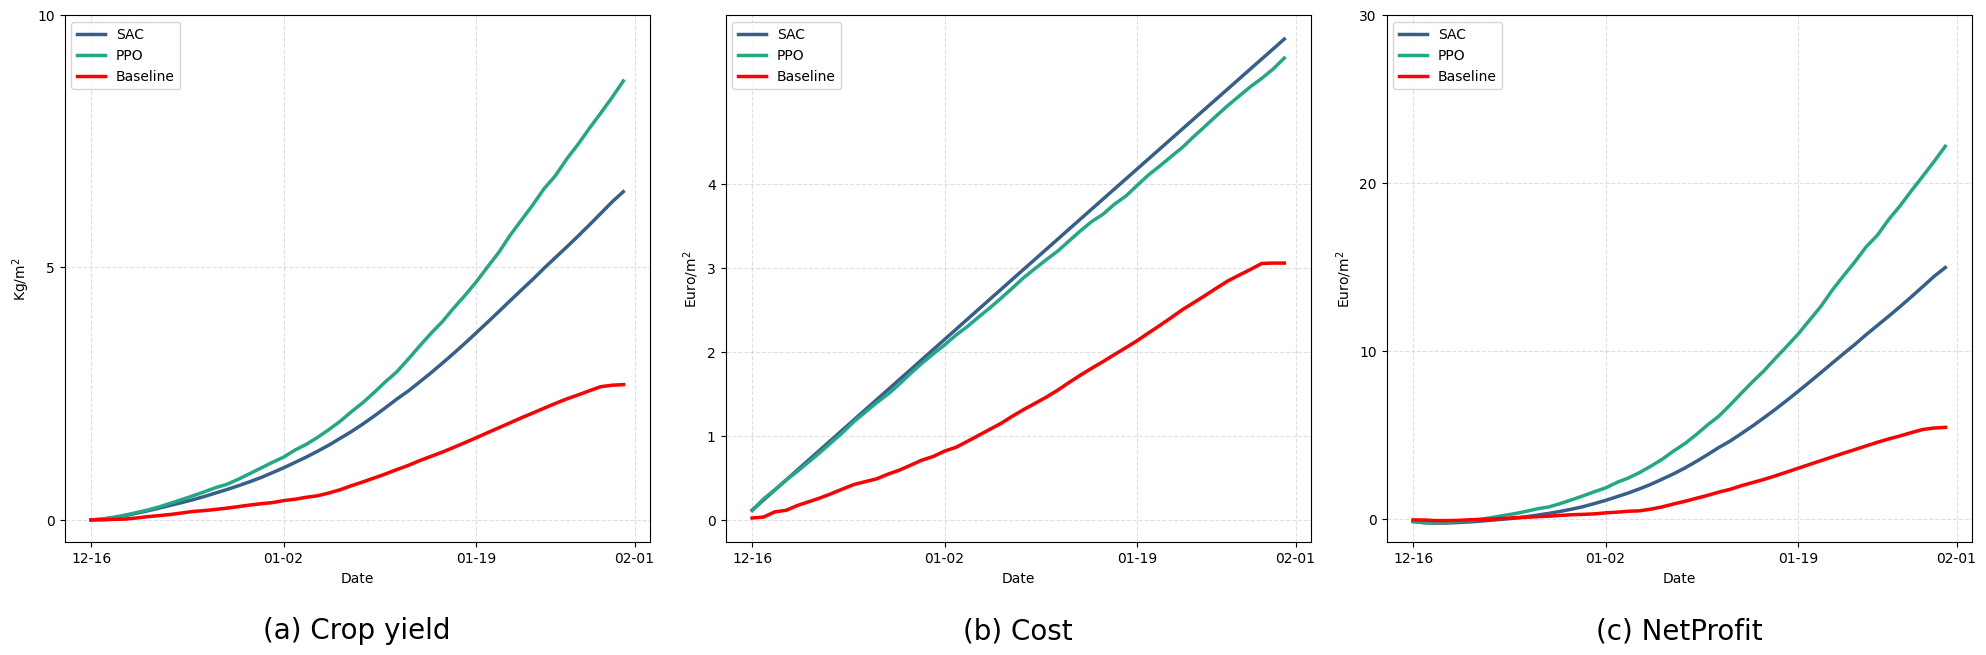

In [63]:
figure(args, env_config)